In [4]:
from datasets import load_dataset
from transformers import BertModel, BertConfig, BertForSequenceClassification, BertTokenizer
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import os

import torch.optim as optim

import matplotlib.pyplot as plt

In [5]:
# parameters

#-- setting custom model
total_l = 9
trans_l = 3
base_model = "bert-base-uncased"
model_name = "transformersbook/bert-base-uncased-finetuned-clinc"

# dataset_name = "clinc_oos", "small"

#-- setting result name
result_name = "clinic_9_3"
model_save_path = f"/mnt/aix7101/jeong/ee/{result_name}.pt"

#-- setting training
train_strategy = "low_lr"  # 'freeze', 'low_lr', 'unfreeze'
num_epoch = 10
num_unfreeze = 3 

In [6]:
dataset = load_dataset("clinc_oos", "small")

In [7]:
from datasets import load_dataset, DatasetDict  # ✅ DatasetDict 추가

dataset = load_dataset("clinc_oos", "small")

# train/val split (예: 80% train, 20% validation)
split_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

# 새로운 DatasetDict로 구성
dataset = DatasetDict({
    "train": split_dataset["train"],
    "validation": split_dataset["test"]
})

In [8]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 6080
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 1520
    })
})


In [9]:
# 컬럼 이름 변경: 'intent' → 'label', 'user_utterance' → 'text'
for split in dataset:
    dataset[split] = dataset[split].rename_columns({
        "intent": "label",
        "text": "text"
    })

In [10]:
# 예시: label 값에서 고유 클래스 목록 추출
unique_labels = list(set(dataset['train']['label']))
label2id = {label: idx for idx, label in enumerate(sorted(unique_labels))}
id2label = {v: k for k, v in label2id.items()}

# 전체 데이터셋에 적용 (train/validation 모두)
def encode_label(example):
    example["label"] = label2id[example["label"]]
    return example

dataset = dataset.map(encode_label)

Map: 100%|██████████| 1520/1520 [00:00<00:00, 16175.94 examples/s]


In [11]:
# 이미 존재하는 DatasetDict에서 분할된 데이터 사용
train_dataset = dataset["train"]
val_dataset = dataset["validation"]

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
dropout = nn.Dropout(p=0.1).to(device) # in BERT default 0.1

In [14]:
# setting
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True, num_labels=151,).eval().to(device)

In [15]:
all_labels = [item["label"] for item in val_dataset]
print("라벨 min:", min(all_labels), "max:", max(all_labels))

라벨 min: 0 max: 150


In [16]:
print("모델 클래스 수:", model.config.num_labels)

모델 클래스 수: 151


In [17]:
from tqdm import tqdm
from sklearn.metrics import f1_score

correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()

for batch in tqdm(val_dataset):
    with torch.no_grad():
        # Tokenize single sample
        inputs = tokenizer(batch["text"], return_tensors="pt", padding=True, truncation=True).to(device)
        label = torch.tensor(batch["label"]).to(device)

        # Predict
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()

        # Accuracy
        correct += int(pred == label.item())
        total += 1

        # F1 계산용 저장
        all_preds.append(pred)
        all_labels.append(label.item())

# Accuracy
acc = correct / total * 100

# F1 Score (macro 방식 추천 - 다중 클래스일 때)
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"✅ Accuracy: {acc:.2f}%")
print(f"✅ F1 Score (macro): {f1:.4f}")

100%|██████████| 1520/1520 [00:10<00:00, 146.02it/s]

✅ Accuracy: 99.08%
✅ F1 Score (macro): 0.9898


## Custom model

In [18]:
from transformers import BertModel, BertConfig, BertForSequenceClassification
import torch.nn as nn
import torch

class CustomBertSmall(nn.Module):
    def __init__(self, teacher_model, total_layers=6, transplanted_layers=3, num_labels=2):
        super().__init__()
        assert transplanted_layers < total_layers, "Transplanted layers must be fewer than total layers"
        
        self.hidden_size = teacher_model.config.hidden_size
        self.total_layers = total_layers
        self.transplanted_layers = transplanted_layers
        self.num_labels = num_labels

        # 그대로 복사할 레이어 인덱스 계산
        transplanted_start = 12 - transplanted_layers
        original_layer_indices = list(range(transplanted_start))[:total_layers - transplanted_layers]

        # Embedding 복사
        self.embeddings = teacher_model.bert.embeddings

        # 선택된 layer만 복사해서 재구성
        self.encoder_layers = nn.ModuleList()

        for idx in original_layer_indices:
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        for idx in range(transplanted_start, 12):
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        # Pooler와 Classifier도 복사
        self.pooler = teacher_model.bert.pooler
        self.dropout = teacher_model.dropout  # from classifier head
        self.classifier = teacher_model.classifier

        self.activation = nn.Tanh()  # 여전히 pooler 내부에서도 사용되지만 보존

    # CustomBertSmall에 hidden_states 옵션 추가
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, output_hidden_states=False):
        hidden_states = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

        if attention_mask is not None:
            extended_attention_mask = attention_mask[:, None, None, :]
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        else:
            extended_attention_mask = None

        all_hidden = []  # 각 레이어 출력 저장
        for layer in self.encoder_layers:
            hidden_states = layer(hidden_states, attention_mask=extended_attention_mask)[0]
            if output_hidden_states:
                all_hidden.append(hidden_states)

        pooled_output = self.pooler(hidden_states)
        pooled_output = self.dropout(self.activation(pooled_output))
        logits = self.classifier(pooled_output)

        if output_hidden_states:
            return logits, all_hidden
        else:
            return logits

In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = "textattack/bert-base-uncased-ag-news"
model_name
# teacher_model = BertForSequenceClassification.from_pretrained(base_model, num_labels=150,)
teacher_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=151,)

small_model = CustomBertSmall(
    teacher_model=teacher_model,
    total_layers=total_l,
    transplanted_layers=trans_l,  # 마지막 l개 레이어 복사
    num_labels=151
).to(device)

## [check] before training

In [16]:
# !export CUDA_LAUNCH_BLOCKING=1

In [17]:
# print(torch.unique(labels))

In [ ]:
# print(tokenizer.vocab_size)
# print(small_model.embeddings.word_embeddings.weight.shape)
# print(model.distilbert.embeddings.word_embeddings.weight.shape)

30522
torch.Size([30522, 768])


AttributeError: 'BertForSequenceClassification' object has no attribute 'distilbert'

In [23]:
from sklearn.metrics import f1_score
from tqdm import tqdm

# Accuracy 카운터
correct_base = 0
correct_small = 0

# F1 계산용 리스트
base_preds = []
small_preds = []
all_labels = []

model.eval()
small_model.eval()

for item in tqdm(val_dataset, desc="Evaluating Small Model"):
    text = item["text"]
    label = item["label"]

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    # inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # BERT-base
        output = model(**inputs)
        logits = output.logits
        pred = torch.argmax(logits, dim=-1).item()

        # Small model
        small_logits = small_model(**inputs)
        small_pred = torch.argmax(small_logits, dim=-1).item()

    correct_base += int(pred == label)
    correct_small += int(small_pred == label)

    # F1 계산용 저장
    base_preds.append(pred)
    small_preds.append(small_pred)
    all_labels.append(label)

# Accuracy
total = len(val_dataset)
acc_base = correct_base / total * 100
acc_small = correct_small / total * 100

# F1 Score (macro 방식 추천)
f1_base = f1_score(all_labels, base_preds, average="macro")
f1_small = f1_score(all_labels, small_preds, average="macro")

# 출력
print(f"\n✅ Accuracy of BERT-base: {acc_base:.2f}%")
print(f"✅ F1 Score of BERT-base: {f1_base:.4f}")

print(f"\n✅ Accuracy of CustomBertSmall: {acc_small:.2f}%")
print(f"✅ F1 Score of CustomBertSmall: {f1_small:.4f}")

Evaluating Small Model: 100%|██████████| 1520/1520 [00:16<00:00, 89.99it/s]


✅ Accuracy of BERT-base: 99.08%
✅ F1 Score of BERT-base: 0.9898

✅ Accuracy of CustomBertSmall: 84.74%
✅ F1 Score of CustomBertSmall: 0.8354


## Custom Loss

In [24]:
import torch.nn.functional as F
from torch.nn import MSELoss, KLDivLoss

def loss1(logits, labels):
    return F.cross_entropy(logits, labels)

# Representation Matching Loss (MSE between CLS tokens)
def loss2(student_hidden, teacher_hidden):
    mse = MSELoss()
    return mse(student_hidden, teacher_hidden)

# DSR Loss (KL Divergence between sorted logits)
def loss3(prev_logits, current_logits, tau=1.0):
    z_prev = torch.sort(prev_logits, dim=-1)[0]
    z_current = torch.sort(current_logits, dim=-1)[0]

    p_prev = F.softmax(z_prev / tau, dim=-1)
    p_current = F.log_softmax(z_current / tau, dim=-1)

    kldiv = KLDivLoss(reduction='batchmean')
    return (tau ** 2 / 2) * kldiv(p_current, p_prev)  # KL(p_prev || p_current)

In [25]:
import torch
import torch.nn.functional as F

def compute_cka(X: torch.Tensor, Y: torch.Tensor, eps=1e-8):
    X = X - X.mean(dim=0, keepdim=True)
    Y = Y - Y.mean(dim=0, keepdim=True)

    dot_product_similarity = (X.T @ Y).norm(p='fro') ** 2
    normalization_x = (X.T @ X).norm(p='fro')
    normalization_y = (Y.T @ Y).norm(p='fro')
    return dot_product_similarity / (normalization_x * normalization_y + eps)

def cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft):
    delta_t = h_teacher_aft - h_teacher_bef
    delta_s = h_student_aft - h_student_bef
    t = delta_t[:, 0, :]  # CLS
    s = delta_s[:, 0, :]
    return 1 - compute_cka(t, s)

## Train

In [26]:
def evaluate(model, val_loader, tokenizer, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            text = batch["text"][0]
            label = batch["label"].item()

            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
            logits = model(**inputs)
            pred = torch.argmax(logits, dim=-1).item()

            correct += int(pred == label)
            total += 1

    return correct / total * 100

In [27]:
import torch

labels = torch.tensor(train_dataset["label"])
print("Label dtype:", labels.dtype)
print("Label min:", labels.min().item())
print("Label max:", labels.max().item())

Label dtype: torch.int64
Label min: 0
Label max: 150


In [28]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW

def train_custom_model(
    model,
    train_dataset,
    val_dataset,
    tokenizer,
    teacher_model=None,  # 👈 custom loss를 쓸 경우 필요
    custom_loss=False,   # 👈 Loss type 선택
    strategy="freeze",
    batch_size=16,
    epochs=10,
    base_lr=5e-5,
    low_lr=5e-6,
    k=3,
    alpha=0.3,           # 👈 custom loss 비중
    unfreeze_epoch=1,
    save_path="best_model.pt",
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model = model.to(device)
    if custom_loss and teacher_model is None:
        raise ValueError("teacher_model must be provided when using custom_loss=True")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    if strategy == "low_lr":
        optimizer_grouped = [
            {"params": [p for l in model.encoder_layers[:-k] for p in l.parameters()], "lr": base_lr},
            {"params": [p for l in model.encoder_layers[-k:] for p in l.parameters()], "lr": low_lr},
            {"params": model.pooler.parameters(), "lr": base_lr},
            {"params": model.classifier.parameters(), "lr": base_lr},
        ]
    else:
        optimizer_grouped = model.parameters()

    optimizer = AdamW(optimizer_grouped, lr=base_lr)
    loss_fn = nn.CrossEntropyLoss()

    if strategy == "freeze":
        for layer in model.encoder_layers[-k:]:
            for param in layer.parameters():
                param.requires_grad = False
        ##-- freeze first layer
        # for param in model.encoder_layers[0].parameters():
        #     param.requires_grad = False

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        print(f"\nEpoch {epoch+1}/{epochs}")

        if strategy == "unfreeze" and epoch == unfreeze_epoch:
            print("--<Unfreezing last K layers>--")
            for layer in model.encoder_layers[-k:]:
                for param in layer.parameters():
                    param.requires_grad = True

        for batch in tqdm(train_loader, desc="Training"):
            texts = batch["text"]
            labels = batch["label"]

            tokenized = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in tokenized.items()}
            labels = labels.to(device)

            optimizer.zero_grad()

            if custom_loss:
                # ----> Custom Loss: CE + CKA delta loss
                logits_small, student_hiddens = model(**inputs, output_hidden_states=True)
                ce_loss = loss_fn(logits_small, labels)

                with torch.no_grad():
                    teacher_outputs = teacher_model(**inputs, output_hidden_states=True)
                    h_teacher_bef = teacher_outputs.hidden_states[(-1)-(k+1)]
                    h_teacher_aft = teacher_outputs.hidden_states[(-1)-k]

                h_student_bef = student_hiddens[(-1)-(k+1)]
                h_student_aft = student_hiddens[(-1)-k]

                cka_loss = cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft)
                loss = ce_loss + alpha * cka_loss
            else:
                # ----> 기본 CE Loss만 사용
                logits = model(**inputs)
                loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Avg Training Loss: {avg_loss:.4f}")

        acc = evaluate(model, val_loader, tokenizer, device)
        print(f"Validation Accuracy: {acc:.2f}%")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ New best model saved with accuracy: {best_acc:.2f}% → {save_path}")

In [29]:
train_custom_model(
    model=small_model,
    teacher_model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    custom_loss=True,              # ✅ 사용
    alpha=0.3,                     # CKA 가중치
    k=trans_l,
    strategy="train_strategy",
    unfreeze_epoch=num_unfreeze,
    epochs=num_epoch,
    save_path=model_save_path
)


Epoch 1/10


Training: 100%|██████████| 380/380 [00:17<00:00, 21.61it/s]


Avg Training Loss: 1.1163


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 198.83it/s]


Validation Accuracy: 94.21%
✅ New best model saved with accuracy: 94.21% → /mnt/aix7101/jeong/ee/clinic_9_3.pt

Epoch 2/10


Training: 100%|██████████| 380/380 [00:17<00:00, 22.11it/s]


Avg Training Loss: 0.3638


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 199.45it/s]


Validation Accuracy: 96.25%
✅ New best model saved with accuracy: 96.25% → /mnt/aix7101/jeong/ee/clinic_9_3.pt

Epoch 3/10


Training: 100%|██████████| 380/380 [00:18<00:00, 20.98it/s]


Avg Training Loss: 0.1638


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 196.29it/s]


Validation Accuracy: 96.78%
✅ New best model saved with accuracy: 96.78% → /mnt/aix7101/jeong/ee/clinic_9_3.pt

Epoch 4/10


Training: 100%|██████████| 380/380 [00:16<00:00, 22.37it/s]


Avg Training Loss: 0.0968


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 200.69it/s]


Validation Accuracy: 97.30%
✅ New best model saved with accuracy: 97.30% → /mnt/aix7101/jeong/ee/clinic_9_3.pt

Epoch 5/10


Training: 100%|██████████| 380/380 [00:17<00:00, 21.80it/s]


Avg Training Loss: 0.0565


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 197.24it/s]


Validation Accuracy: 96.58%

Epoch 6/10


Training: 100%|██████████| 380/380 [00:17<00:00, 21.98it/s]


Avg Training Loss: 0.0440


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 202.40it/s]


Validation Accuracy: 97.04%

Epoch 7/10


Training: 100%|██████████| 380/380 [00:16<00:00, 22.41it/s]


Avg Training Loss: 0.0420


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 199.55it/s]


Validation Accuracy: 96.25%

Epoch 8/10


Training: 100%|██████████| 380/380 [00:16<00:00, 22.48it/s]


Avg Training Loss: 0.0578


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 201.13it/s]


Validation Accuracy: 96.45%

Epoch 9/10


Training: 100%|██████████| 380/380 [00:18<00:00, 21.05it/s]


Avg Training Loss: 0.0401


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 195.07it/s]


Validation Accuracy: 96.64%

Epoch 10/10


Training: 100%|██████████| 380/380 [00:17<00:00, 21.35it/s]


Avg Training Loss: 0.0590


Evaluating: 100%|██████████| 1520/1520 [00:07<00:00, 202.61it/s]

Validation Accuracy: 96.32%


In [27]:
# # 학습 시작
# train_custom_model(
#     model=small_model,
#     train_dataset=train_dataset,
#     val_dataset=val_dataset,
#     tokenizer=tokenizer,
#     strategy=train_strategy,  # 'freeze', 'low_lr', 'unfreeze'
#     epochs=num_epoch,
#     batch_size=16,
#     base_lr=5e-5,
#     low_lr=5e-6,
#     k=2,  # 마지막 3개 레이어를 보존
#     unfreeze_epoch=num_unfreeze,
#     save_path=model_save_path
# )

## [check] after training

In [30]:
# load model

small_model.load_state_dict(torch.load(model_save_path, map_location=device))
small_model = small_model.eval().to(device)


In [31]:
# for accuracy with small model
correct_base = 0
correct_small = 0

model.eval()
small_model.eval()

for item in tqdm(val_dataset, desc="Evaluating Small Model"):
    text = item["text"]
    label = item["label"]

    # inputs
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    # Teacher model (BertForSequenceClassification)
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits  # SequenceClassifierOutput에서 logits 추출
        pred = torch.argmax(logits, dim=-1).item()

    # Small model (CustomBertSmall)
    with torch.no_grad():
        small_logits = small_model(**inputs)  # 직접 logits 반환
        small_pred = torch.argmax(small_logits, dim=-1).item()
    
    correct_base += int(pred==label)
    correct_small += int(small_pred == label)

# 정확도 출력
total = len(val_dataset)
print(f"\n✅ Accuracy of Bertbase: {correct_base / total * 100:.2f}%")
print(f"\n✅ Accuracy of CustomBertSmall: {correct_small / total * 100:.2f}%")

Evaluating Small Model: 100%|██████████| 1520/1520 [00:16<00:00, 90.89it/s]


✅ Accuracy of Bertbase: 99.08%

✅ Accuracy of CustomBertSmall: 97.30%


In [ ]:
import torch.nn as nn

layer = 5  # 원하는 layer
dropout = nn.Dropout(0.1)
inputs = tokenizer("example sentence", return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    hidden = outputs.hidden_states[layer]  # [batch_size, seq_len, hidden_dim]
    pooled = hidden[:, 0]  # [CLS] 토큰 추출

    pooled_dropped = dropout(pooled)
    logits_orig = model.classifier(pooled_dropped)

In [37]:
# 정확도 저장 리스트
acc_original = []
acc_small = [0] * total_l  # ✅ small_model의 레이어 수만큼 정확도 저장

for layer in range(1, 13):  # BERT-base: layer 1~12
    correct_orig = 0
    correct_small_by_layer = [0] * total_l  # 각 small layer의 정답 수
    total = 0

    for item in tqdm(val_dataset, desc=f"Layer {layer}"):
        text = item["text"]
        label = item["label"]
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

        with torch.no_grad():
            # BERT-base layer별 정확도
            outputs = model(**inputs)
            hidden = outputs.hidden_states[layer]
            pooled = model.bert.pooler(hidden)
            pooled_dropped = dropout(pooled)
            logits_orig = model.classifier(pooled_dropped)
            pred_orig = torch.argmax(logits_orig).item()

            # small model: 전체 forward + hidden states
            logits_small, small_hidden_states = small_model(**inputs, output_hidden_states=True)

            for i, h in enumerate(small_hidden_states):
                pooled_small = small_model.pooler(h)  # CLS 포함
                pooled_small = dropout(pooled_small)
                logits = small_model.classifier(pooled_small)
                pred = torch.argmax(logits, dim=-1).item()
                correct_small_by_layer[i] += int(pred == label)

            correct_orig += int(pred_orig == label)
            total += 1

    acc_original.append(correct_orig / total)

    # 마지막 layer 기준에서 정확도 누적 (1 epoch 끝났을 때만 기록됨)
    if layer == 12:
        acc_small = [c / total for c in correct_small_by_layer]

Layer 12: 100%|██████████| 1520/1520 [00:18<00:00, 82.06it/s]


In [38]:
len(outputs.hidden_states)  # → 7

13

In [39]:
acc_original

[0.003947368421052632,
 0.007894736842105263,
 0.009868421052631578,
 0.009210526315789473,
 0.009210526315789473,
 0.014473684210526316,
 0.03289473684210526,
 0.02894736842105263,
 0.053289473684210525,
 0.2513157894736842,
 0.781578947368421,
 0.9894736842105263]

In [40]:
acc_small

[0.007894736842105263,
 0.01118421052631579,
 0.0059210526315789476,
 0.007236842105263158,
 0.009210526315789473,
 0.05263157894736842,
 0.31842105263157894,
 0.8657894736842106,
 0.9730263157894737]

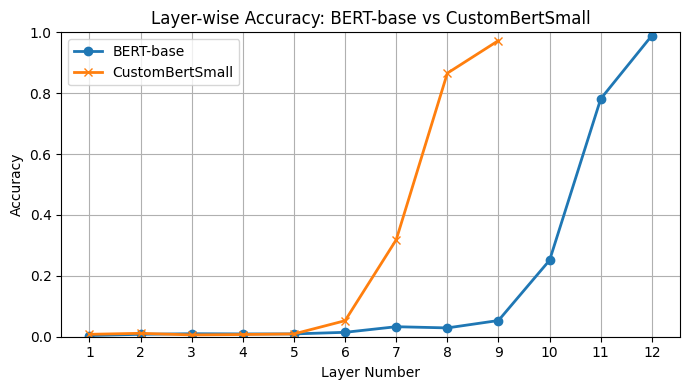

In [41]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 13), acc_original, label="BERT-base", marker='o', linewidth=2)
plt.plot(range(1, total_l + 1), acc_small, label="CustomBertSmall", marker='x', linewidth=2)
plt.xlabel("Layer Number")
plt.ylabel("Accuracy")
plt.title("Layer-wise Accuracy: BERT-base vs CustomBertSmall")
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig(f"img/{result_name}.png", dpi=300)
plt.show()